In [ ]:
!pip install langchain_openai langchain_core langgraph 

In [1]:
import uuid
from typing import Annotated
# from langchain_core.messages import AIMessage
from langchain_openai import ChatOpenAI
from langchain_core.runnables import RunnableConfig
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.store.base import BaseStore
from typing import Annotated, Optional
from langchain_core.tools import InjectedToolArg, tool

from langgraph.store.memory import InMemoryStore
from langgraph.checkpoint.memory import MemorySaver
in_memory_store = InMemoryStore()

In [2]:

@tool
def upsert_memory(
    content: str,
    context: str,
    memory_id: Optional[str] = None,
    *,
    config: Annotated[RunnableConfig, InjectedToolArg],
    store: Annotated[BaseStore, InjectedToolArg],
):
    """Upsert a memory in the database.

    If a memory conflicts with an existing one, then just UPDATE the
    existing one by passing in memory_id - don't create two memories
    that are the same. If the user corrects a memory, UPDATE it.

    Args:
        content: The main content of the memory. For example:
            "User expressed interest in learning about French."
        context: Additional context for the memory. For example:
            "This was mentioned while discussing career options in Europe."
        memory_id: ONLY PROVIDE IF UPDATING AN EXISTING MEMORY.
        The memory to overwrite.
    """
    mem_id = memory_id or uuid.uuid4()
    user_id = config["configurable"]["user_id"]
    store.put(
        ("memories", user_id),
        key=str(mem_id),
        value={"content": content, "context": context},
    )
    return f"Stored memory {mem_id}"

In [4]:
model = ChatOpenAI(model="gpt-4o")

def store_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):
    # Extract tool calls from the last message
    tool_calls = state["messages"][-1].tool_calls
    saved_memories=[]
    for tc in tool_calls:
        content = tc['args']['content']
        context = tc['args']['context']
        saved_memories.append([
            upsert_memory.invoke({'content': content, 'context': context, 'config':config, 'store':store})  
        ])
    # print("saved_memories: ", saved_memories)
    # Format the results of memory storage operations
    # This provides confirmation to the model that the actions it took were completed
    results = [
        {
            "role": "tool",
            "content": mem[0],
            "tool_call_id": tc["id"],
        }
        for tc, mem in zip(tool_calls, saved_memories)
    ]
    # print(results)
    return {"messages": results[0]}

def route_message(state: MessagesState):
    """Determine the next step based on the presence of tool calls."""
    msg = state["messages"][-1]
    if msg.tool_calls:
        # If there are tool calls, we need to store memories
        return "store_memory"
    # Otherwise, finish; user can send the next message
    return END

def call_model(state: MessagesState, config: RunnableConfig, *, store: BaseStore):
    user_id = config["configurable"]["user_id"]
    namespace = ("memories", user_id)
    memories = store.search(namespace)
    info = "\n".join(f"[{mem.key}]: {mem.value}" for mem in memories)
    if info:
        info = f"""
    <memories>
    {info}
    </memories>"""
    
    system_msg = f'''You are a helpful assistant talking to the user. You must decide whether to store information as memory from list of messages and then answer the user query or directly answer the user query
        User context info: {info}'''
    print("system_msg:", system_msg)
    # Store new memories if the user asks the model to remember
    last_message = state["messages"][-1]
    # if "remember" in last_message.content.lower():
    #     memory = "User name is Bob"
    #     store.put(namespace, str(uuid.uuid4()), {"data": memory})
    # print( [{"type": "system", "content": system_msg}] + state["messages"])
    response = model.bind_tools([upsert_memory]).invoke(
        [{"type": "system", "content": system_msg}] + state["messages"]
    )
    return {"messages": response}


builder = StateGraph(MessagesState)
builder.add_node("call_model", call_model)
builder.add_edge(START, "call_model")

builder.add_node(store_memory)

builder.add_conditional_edges("call_model", route_message, ["store_memory", END])

builder.add_edge("store_memory", "call_model")

graph = builder.compile(store=in_memory_store)

In [5]:
config = {"configurable": {"thread_id": "1", "user_id": "1"}}
input_message = {"type": "user", "content": "Hi! My name is Bob. I love keep updated on Latest Tech"}
for chunk in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi! Remember: my name is Bob
system_msg: You are a helpful assistant talking to the user. You must decide whether to store information as memory from list of messages and then answer the user query or directly answer the user query
        User context info: 
[{'type': 'system', 'content': 'You are a helpful assistant talking to the user. You must decide whether to store information as memory from list of messages and then answer the user query or directly answer the user query\n        User context info: '}, HumanMessage(content='Hi! Remember: my name is Bob', additional_kwargs={}, response_metadata={}, id='7ce923c3-1b4c-4487-891f-40273067f60b')]
================================== Ai Message ==================================
Tool Calls:
  upsert_memory (call_PrjfPMYG7sYUlJJE6gdMQSWQ)
 Call ID: call_PrjfPMYG7sYUlJJE6gdMQSWQ
  Args:
    content: User's name is Bob.
    context: User mentioned their name.


In [6]:
config = {"configurable": {"thread_id": "1", "user_id": "1"}}
input_message = {"type": "user", "content": "What do you know about me"}
for chunk in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

What do you know about me
system_msg: You are a helpful assistant talking to the user. You must decide whether to store information as memory from list of messages and then answer the user query or directly answer the user query
        User context info: 
    <memories>
    [e424aeb4-7cb0-4c1f-90ed-efb7da4333c7]: {'content': "User's name is Bob.", 'context': 'User mentioned their name.'}
    </memories>
[{'type': 'system', 'content': 'You are a helpful assistant talking to the user. You must decide whether to store information as memory from list of messages and then answer the user query or directly answer the user query\n        User context info: \n    <memories>\n    [e424aeb4-7cb0-4c1f-90ed-efb7da4333c7]: {\'content\': "User\'s name is Bob.", \'context\': \'User mentioned their name.\'}\n    </memories>'}, HumanMessage(content='What do you know about me', additional_kwargs={}, response_metadata={}, 

In [7]:
namespace = ("memories", "1")
memories = in_memory_store.search(namespace)
info = "\n".join(f"[{mem.key}]: {mem.value}" for mem in memories)
print(info)

[e424aeb4-7cb0-4c1f-90ed-efb7da4333c7]: {'content': "User's name is Bob.", 'context': 'User mentioned their name.'}


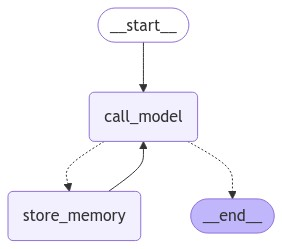

In [8]:
from IPython.display import Image, display
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(e)